In [2]:
!pip install -q geopandas shapely pyproj fiona rtree contextily folium mapclassify

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from shapely.ops import unary_union
import warnings, platform
warnings.filterwarnings('ignore')

print("✅ Librerías listas")
print(f"GeoPandas: {gpd.__version__}")
print(f"Python: {platform.python_version()}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ Librerías listas
GeoPandas: 1.0.1
Python: 3.10.13


In [3]:
radios = gpd.read_file("https://bitsandbricks.github.io/data/CABA_rc.geojson")
print(radios.crs)
print(radios.head())

print("Filas:", len(radios))
print("Geometrías vacías:", radios.geometry.is_empty.sum())
print("Geometrías nulas:", radios.geometry.isna().sum())

EPSG:4326
  RADIO_ID       BARRIO COMUNA  POBLACION  VIVIENDAS  HOGARES  HOGARES_NBI  \
0    1_1_1       RETIRO      1      336.0       82.0     65.0         19.0   
1   1_12_1  SAN NICOLAS      1      341.0      365.0    116.0         25.0   
2  1_12_10  SAN NICOLAS      1      296.0      629.0    101.0          1.0   
3  1_12_11  SAN NICOLAS      1      528.0      375.0    136.0          7.0   
4   1_12_2  SAN NICOLAS      1      229.0      445.0    129.0         16.0   

   AREA_KM2                                           geometry  
0  1.798997  MULTIPOLYGON (((-58.37189 -34.59199, -58.37202...  
1  0.018565  MULTIPOLYGON (((-58.38593 -34.60444, -58.38575...  
2  0.044380  MULTIPOLYGON (((-58.37879 -34.60528, -58.37741...  
3  0.366340  MULTIPOLYGON (((-58.36733 -34.60562, -58.36713...  
4  0.018363  MULTIPOLYGON (((-58.38454 -34.60436, -58.38311...  
Filas: 3554
Geometrías vacías: 0
Geometrías nulas: 0


In [ ]:
# ⚠️ COMPLETA: proyecta a CRS métrico (3857 recomendado si no sabes uno local)
radios_m = radios.to_crs(epsg=3857)

radios_m["area_m2"] = radios_m.geometry.area
radios_m["densidad_hab_km2"] = radios_m["POBLACION"] / (radios_m["area_m2"] / 1e6)

radios_m[["BARRIO", "POBLACION", "AREA_KM2", "area_m2", "densidad_hab_km2"]].head()

,BARRIO,POBLACION,AREA_KM2,area_m2,densidad_hab_km2
0,RETIRO,336.0,1.798997,2.660685e+06,126.283256
1,SAN NICOLAS,341.0,0.018565,2.746859e+04,12414.178936
2,SAN NICOLAS,296.0,0.044380,6.566604e+04,4507.657512
3,SAN NICOLAS,528.0,0.366340,5.420509e+05,974.078198
4,SAN NICOLAS,229.0,0.018363,2.717014e+04,8428.368902


In [13]:
# Top 3 radios por densidad (hab/km²)
top3 = radios_m.nlargest(3, "densidad_hab_km2")[["RADIO_ID", "BARRIO", "POBLACION", "area_m2", "densidad_hab_km2"]].copy()
top3["densidad_hab_km2"] = top3["densidad_hab_km2"].round(2)
top3["area_km2"] = (top3["area_m2"] / 1e6).round(6)
print(top3.reset_index(drop=True))

  RADIO_ID  BARRIO  POBLACION       area_m2  densidad_hab_km2  area_km2
0   7_17_4  FLORES     1645.0  14927.311765         110200.69  0.014927
1   1_3_16  RETIRO      726.0   6607.472859         109875.59  0.006607
2    1_3_8  RETIRO      797.0   7298.887482         109194.72  0.007299


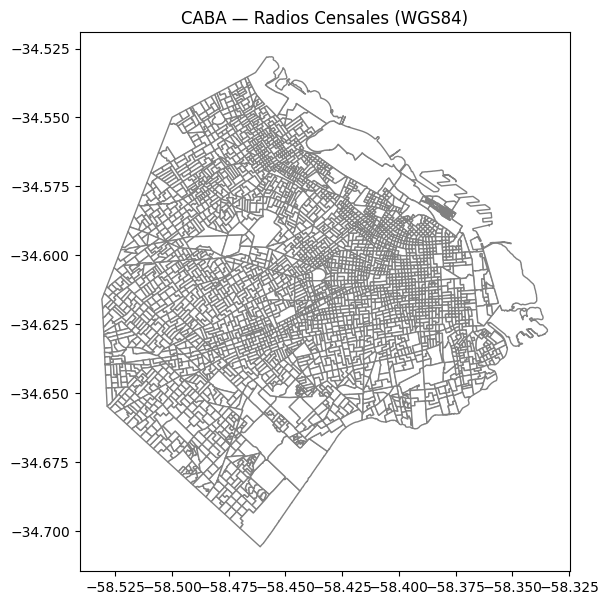

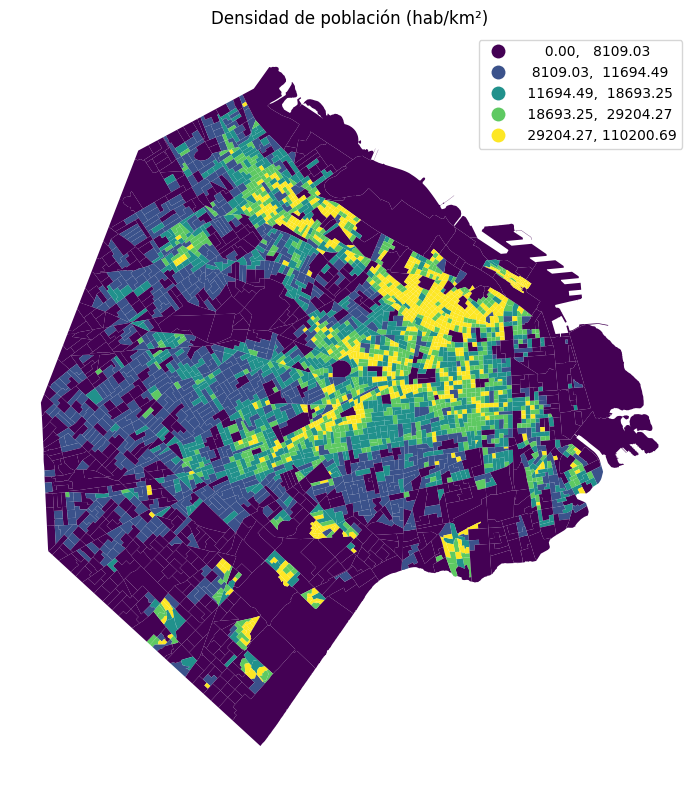

In [5]:
ax = radios.plot(figsize=(7,7), edgecolor="gray", facecolor="white")
ax.set_title("CABA — Radios Censales (WGS84)")
plt.show()

# Densidad por km² (proyectado)
ax = radios_m.plot(column="densidad_hab_km2", scheme='quantiles', k=5,
                   legend=True, cmap="viridis", figsize=(8,8), linewidth=0)
ax.set_axis_off()
ax.set_title("Densidad de población (hab/km²)")
plt.tight_layout(); plt.show()

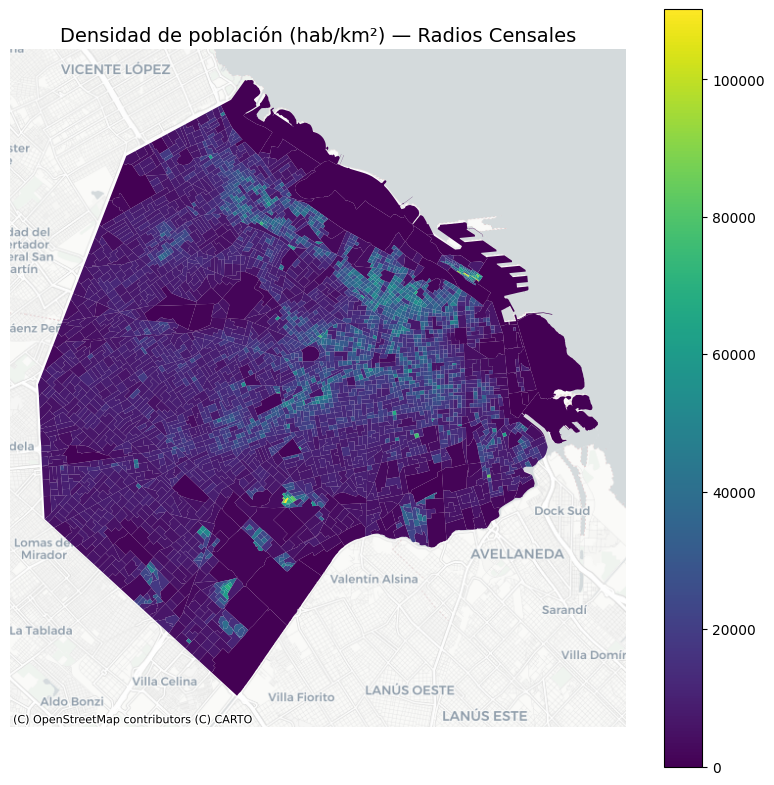

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
radios_m.to_crs(epsg=3857).plot(ax=ax, column="densidad_hab_km2", cmap="viridis", legend=True, linewidth=0)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title("Densidad de población (hab/km²) — Radios Censales", fontsize=14)
ax.set_axis_off(); plt.tight_layout(); plt.show()

Preguntas de reflexión — Parte A (completa los espacios)¶

1) ¿Qué esquema de clasificación fue más informativo para la coropleta (quantiles, k=5)? - Qué buscar: homogeneidad de rangos vs cortes que separen outliers; mapas legibles sin bandas vacías.
   
   En el primero, cada radio censal está coloreado según su densidad de población y usa una clasificación en quantiles, que reparte los radios en 5 grupos con igual cantidad de elementos, lo que ayuda a resaltar contrastes visuales en la variable. El segundo usa la información superpuesta sobre un mapa base gracias a contextily. Creemos que este gráfico mejora la interpretación visual, mostrando en qué zonas concretas se concentran las áreas más densas.

2) En la proyección elegida, la variable que normalizaste para densidad fue: POBLACION, que se divide por 1e6 para convertirla a kilómetros cuadrados. Así, la unidad final es habitantes por kilómetro cuadrado, para comparar densidad poblacional. - Qué buscar: confirmar que el divisor está en m² y transformar a km².

3) Identifica 2 zonas con mayor densidad: Zona 1 = barrio flores; Zona 2 = barrio retiro .- Qué buscar: barrios identificables por la coropleta; contrastar con conocimiento urbano.

In [7]:
suaci = pd.read_csv("http://bitsandbricks.github.io/data/gcba_suaci_comunas.csv", encoding='ISO-8859-1')
suaci_barrio = suaci.groupby("BARRIO", as_index=False)["total"].sum()

# Agregado geográfico por barrio (disolver)
barrios_m = (radios_m
             .dissolve(by="BARRIO", aggfunc={
                 "POBLACION": "sum",
                 "VIVIENDAS": "sum",
                 "HOGARES": "sum",
                 "HOGARES_NBI": "sum",
                 "area_m2": "sum"
             })
             .reset_index())

barrios_m = barrios_m.merge(suaci_barrio, on="BARRIO", how="left")
barrios_m["contactos_pc"] = barrios_m["total"] / barrios_m["POBLACION"]

barrios_m[["BARRIO", "POBLACION", "total", "contactos_pc" ]].sort_values("contactos_pc", ascending=False).head(10)

,BARRIO,POBLACION,total,contactos_pc
31,SAN NICOLAS,29273.0,399369.0,13.642913
16,MONSERRAT,39914.0,227337.0,5.695671
34,VERSALLES,13822.0,12414.0,0.898133
37,VILLA DEVOTO,66521.0,57558.0,0.865261
43,VILLA REAL,13419.0,11225.0,0.836500
17,MONTE CASTRO,33623.0,24925.0,0.741308
44,VILLA RIACHUELO,14084.0,10405.0,0.738782
41,VILLA ORTUZAR,21736.0,15896.0,0.731321
45,VILLA SANTA RITA,33325.0,23720.0,0.711778
9,COGHLAN,18604.0,13105.0,0.704418


In [15]:
# Top 3 contactos per cápita por barrio
top3 = barrios_m.nlargest(3, "contactos_pc")[["BARRIO", "POBLACION", "total", "contactos_pc"]].copy()
top3["contactos_pc"] = top3["contactos_pc"].round(3)
print(top3.reset_index(drop=True))

        BARRIO  POBLACION     total  contactos_pc
0  SAN NICOLAS    29273.0  399369.0        13.643
1    MONSERRAT    39914.0  227337.0         5.696
2    VERSALLES    13822.0   12414.0         0.898


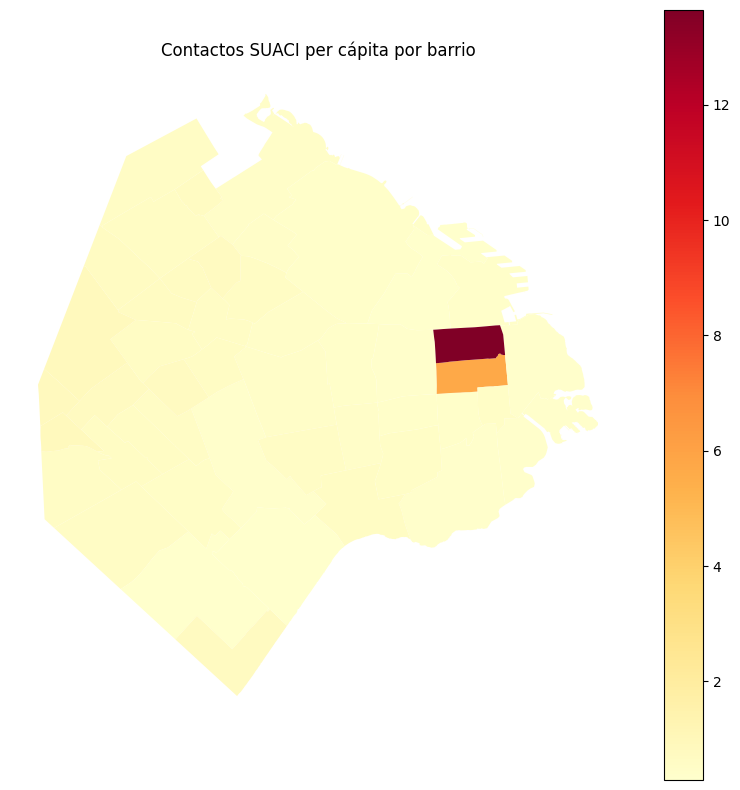

In [8]:
# Coropleta per cápita por barrio
ax = barrios_m.plot(column="contactos_pc", cmap='YlOrRd', legend=True,
                    figsize=(8,8), linewidth=0)
ax.set_axis_off(); ax.set_title("Contactos SUACI per cápita por barrio")
plt.tight_layout(); plt.show()

📝 Preguntas de reflexión — Parte B (completa los espacios)¶

1) La métrica per cápita calculada fue contactos_pc = barrios_m["total"] / barrios_m["POBLACION"]. ¿Por qué es preferible a valores absolutos? evita el sesgo por tamaño poblacional, permitiendo comparar barrios de distinta cantidad de habitantes en igualdad de condiciones.
   
2) Top‑3 barrios por contactos_pc: 1) san nicolas 2) monserrat 3) versalles. ¿Qué patrón común observas? Son barrios centrales o con alta concentración de oficinas, instituciones públicas y actividad comercial/administrativa, lo que genera mayor interacción con el sistema SUACI aunque la población residente sea relativamente baja. 

3) ¿Qué columna usarías para segmentar por tipo de solicitud si existiera? Nombre de columna: _. Métrica: Usaríamos una columna llamada RUBRO para clasificar los contactos según categoría (por ejemplo: reclamos tránsito, limpieza, etc.) y una métrica de tasa por cada 1.000 habitantes para analizar qué barrios presentan mayor demanda en cada tipo de servicio.

In [17]:
# Encuentra el barrio con mayor dist_min_m (peor cobertura)
# (usa las variables ya creadas: barrios_m, gpd)
idx = barrios_m['dist_min_m'].idxmax()
peor = barrios_m.loc[idx] 

print("Peor cobertura (mayor dist_min_m):")
print(peor[["BARRIO","dist_min_m"]])

# Mostrar top 5 barrios con peor cobertura
print("\nTop 5 barrios con mayor dist_min_m:")
print(barrios_m.nlargest(5, "dist_min_m")[["BARRIO"]].reset_index(drop=True))

Peor cobertura (mayor dist_min_m):
BARRIO        VILLA RIACHUELO
dist_min_m         6636.09839
Name: 44, dtype: object

Top 5 barrios con mayor dist_min_m:
            BARRIO
0  VILLA RIACHUELO
1       VILLA REAL
2        VERSALLES
3          LINIERS
4     VILLA DEVOTO


📝 Preguntas de reflexión — Parte C (completa los espacios)¶

1) ¿Qué relación esperas entre estaciones_por_km2 y contactos_pc? Correlación esperada: directa, porque los barrios con más estaciones por km² suelen tener mayor flujo de personas, actividad comercial y administrativa.
En otras palabras, más movilidad y servicios da más interacción ciudadana y más reclamos por persona.

1) Barrio con menor cobertura (mayor dist_min_m): Villa riachuelo. Posible causa: está en periferia, áreas portuarias/industriales, espacios verdes extensos.

2) Si tuvieras que priorizar nuevas estaciones, define un criterio: score = α·(dist_min) + β·(contactos_pc). Valores α, β: 0.5 ambos para darle igual importancia y combinar distancia, densidad y demanda (contactos).

In [9]:
lineas = gpd.read_file("http://bitsandbricks.github.io/data/subte_lineas.geojson").to_crs(barrios_m.crs)
estaciones = gpd.read_file("http://bitsandbricks.github.io/data/subte_estaciones.geojson").to_crs(barrios_m.crs)

# Conteo de estaciones por barrio (puntos dentro de polígonos)
est_x_barrio = gpd.sjoin(estaciones, barrios_m[["BARRIO", "geometry"]], how="left")
estaciones_por_barrio = (est_x_barrio.groupby("BARRIO").size()
                         .rename("n_estaciones").reset_index())

barrios_m = barrios_m.merge(estaciones_por_barrio, on="BARRIO", how="left")
barrios_m["n_estaciones"] = barrios_m["n_estaciones"].fillna(0).astype(int)

# Densidad estaciones por km²
barrios_m["estaciones_por_km2"] = barrios_m["n_estaciones"] / (barrios_m["area_m2"] / 1e6)

barrios_m[["BARRIO", "n_estaciones", "estaciones_por_km2"]].sort_values(["estaciones_por_km2", "n_estaciones"], ascending=False).head(12)

,BARRIO,n_estaciones,estaciones_por_km2
16,MONSERRAT,10,3.074451
31,SAN NICOLAS,9,2.656840
2,BALVANERA,11,1.711873
30,SAN CRISTOBAL,5,1.652844
11,CONSTITUCION,4,1.284964
27,RECOLETA,7,0.754127
1,ALMAGRO,4,0.667414
7,CABALLITO,6,0.591765
24,PARQUE PATRICIOS,3,0.541203
23,PARQUE CHAS,1,0.488211


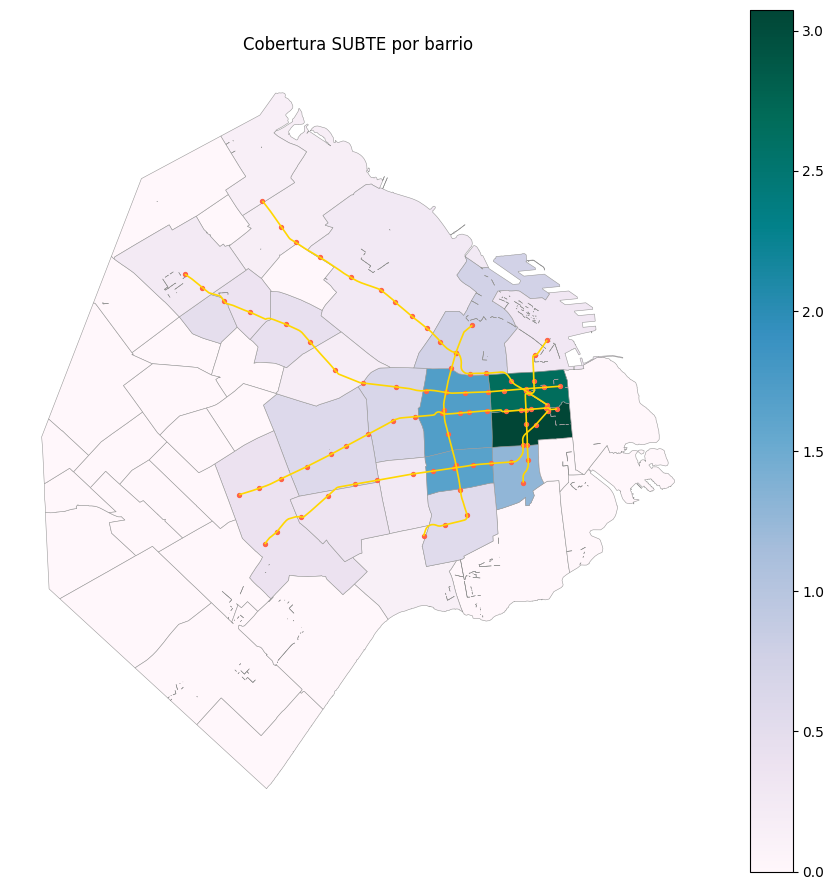

In [10]:
# Mapa: estaciones por km² + líneas del SUBTE
fig, ax = plt.subplots(figsize=(9,9))
barrios_m.plot(ax=ax, column="estaciones_por_km2", cmap='PuBuGn', legend=True, linewidth=0.4, edgecolor="#999")
lineas.plot(ax=ax, color="gold", linewidth=1.2)
estaciones.plot(ax=ax, color="tomato", markersize=8)
ax.set_axis_off(); ax.set_title("Cobertura SUBTE por barrio")
plt.tight_layout(); plt.show()

In [11]:
# ⚠️ COMPLETA: usa sjoin_nearest para distancia mínima a una estación por barrio (centroides)
barrios_centroides = barrios_m.copy()
barrios_centroides["geometry"] = barrios_centroides.geometry.centroid

nearest = gpd.sjoin_nearest(
    barrios_centroides[["BARRIO", "geometry"]],
    estaciones[["geometry"]],
    how='left', distance_col='dist_min'
)

barrios_m = barrios_m.merge(nearest[["BARRIO", "dist_min"]], on="BARRIO", how="left")
barrios_m["dist_min_m"] = barrios_m["dist_min"].astype(float)

barrios_m[["BARRIO", "n_estaciones", "dist_min_m"]].sort_values("dist_min_m").head(10)

,BARRIO,n_estaciones,dist_min_m
31,SAN NICOLAS,9,75.421711
2,BALVANERA,11,145.300101
16,MONSERRAT,10,168.520516
30,SAN CRISTOBAL,5,193.293898
35,VILLA CRESPO,1,265.186475
8,CHACARITA,2,272.669864
1,ALMAGRO,4,292.896357
47,VILLA URQUIZA,2,329.562801
28,RETIRO,2,347.115753
27,RECOLETA,7,349.109564


In [12]:
import folium
from folium import Choropleth, Marker

barrios_ll = barrios_m.to_crs(epsg=4326)

m = folium.Map(location=[-34.61, -58.44], tiles='cartodbpositron', zoom_start=11)
Choropleth(
    geo_data=barrios_ll.__geo_interface__,
    data=barrios_ll.set_index("BARRIO")["contactos_pc"],
    key_on="feature.properties.BARRIO",
    fill_color='YlOrRd', legend_name='Contactos per cápita'
).add_to(m)

# Puntos de estaciones
for _, row in estaciones.to_crs(epsg=4326).iterrows():
    Marker([row.geometry.y, row.geometry.x], icon=folium.Icon(color='red', icon='train', prefix='fa')).add_to(m)

m

📝 Preguntas de reflexión — Parte D (completa los espacios)¶

1) ¿Qué capa usarías para permitir toggles en el mapa (encender/apagar)? Respuesta: usaría folium.FeatureGroup para cada capa temática (por ejemplo: una para barrios, otra para estaciones de SUBTE, otra para contactos SUACI) y luego agregaría un folium.LayerControl(). 
   
   ¿Por qué? Porque FeatureGroup permite agrupar objetos en capas separadas y LayerControl agrega el panel de checkboxes para poder encender/apagar cada grupo sin recargar el mapa.

2) ¿Qué tiles mejorarían el contraste de una coropleta intensa? Opción: CartoDB.PositronNoLabels (o, alternativamente, Esri.WorldGrayCanvas).
Estos fondos grises y sin elementos muy saturados hacen que los colores de la coropleta destaquen más y reducen el “ruido visual” del mapa base.

3) ¿Qué popup mostrarías al clickear una estación? Campos: nombre de la estación, línea a la que pertenece y barrio en el que se encuentra.
De esa forma el usuario puede entender rápidamente qué estación es, de qué línea y en qué zona de la ciudad está ubicada.

Preguntas de reflexión finales (completa los espacios)¶

1) Usar CRS proyectado (EPSG: 3857) cambió las áreas/distancias porque ahora están en metros (y km² al normalizar), evitando trabajar con grados de latitud/longitud que no representan distancias reales ni áreas comparables.
   
2) Normalizar por km² y per cápita evita que el mapa refleje solo el tamaño bruto de la población o del barrio. La métrica que más cambió mi interpretación fue contactos_pc (contactos SUACI per cápita) porque mostró que los barrios centrales como San Nicolás y Monserrat tienen mucha más interacción por persona que otros con más habitantes pero menos actividad administrativa.

3) La zona con peor cobertura (mayor dist_min_m) es Villa Riachuelo; propondría evaluar una nueva estación en (coordenadas aproximadas) considerando como criterio la combinación de alta distancia al SUBTE, los patrones de movilidad hacia el centro y la posibilidad de conectar con otros modos (colectivos y ferrocarril) para reducir tiempos de viaje.

4) Limitaciones técnicas detectadas: 
   (i) Formato vectorial GeoJSON para capas grandes: puede ser pesado y lento de cargar; mitigaciones: usar formatos más eficientes como GeoPackage/Parquet y, cuando sea posible, simplificar geometrías antes de visualizarlas. 
   (ii) encoding de CSV mezcla de UTF-8 e ISO-8859-1): puede producir errores de lectura o caracteres raros. Mitigación: especificar siempre el parámetro encoding correcto al leer (encoding="ISO-8859-1" o utf-8) y documentar el encoding de origen.

5) Checklist de calidad que aplicarías en un pipeline productivo: CRS consistente, geometrías válidas, índices espaciales, tests de conteo/áreas, documentación de fuentes/licencias. Marca lo que cumpliste hoy: [ ] CRS [ ] geometrías [ ] índices [ ] tests [ ] docs.

    - CRS consistente ✅ (reproyección a EPSG:3857 y vuelta a 4326 para el mapa interactivo).

    - Geometrías válidas ✅ (se verificó que no hubiera geometrías vacías o nulas).

    - Índices espaciales ⬜ (no se configuraron explícitamente índices, se usó el comportamiento por defecto).

    - Tests de conteo/áreas ✅ (revisión de número de filas, areas, densidades y top-N por barrio).

    - Documentación de fuentes/licencias ✅ (quedan registradas en el notebook y en la entrada del portfolio).